# <center>Scaling XGBoost Hyper-Parameter Optimization</center>

<img src="images/swarm.png" width="400"/>

# Motivation:

To reach highest performance in classification tasks (i.e., supervised learning ), it is best practice to build an ensemble of champion models. 

Each member of the ensemble is a winner of a search over many models of its kind with altered hyper-parameters.

In this notebook, we build a harness for running such a [hyper-parameter] search to demonstrate the accuracy benefits while exploring performance as we scale within and accross GPU nodes.

# Library Imports:

In [1]:
import ipyvolume as ipv
import matplotlib.pyplot as plt

import numpy as np; import pandas as pd; import cudf
import cuml; import xgboost; from xgboost import plot_tree

import warnings; warnings.filterwarnings('ignore')
import time; import copy

import data_utils
import swarm
import visualization as viz

# reload library modules/code without a kernel restart
import importlib; importlib.reload( swarm ); importlib.reload( data_utils ); importlib.reload( viz);

# Dataset:

<center> In this notebook you can try different hyper-parameter search methods using synthetic or real data. </center>


<img src="images/datasets.png" width="1000"/>

# Data Ingestion / Generation

In [2]:
%%time
# dataset = data_utils.Dataset( 'fashion-mnist')
# dataset = data_utils.Dataset( 'airline', nSamples = 1000000)
#dataset = data_utils.Dataset( 'synthetic', coilType = 'helix', coilDensity = 9, nSamples = 1000000)
dataset = data_utils.Dataset( 'synthetic', coilType = 'whirl', coilDensity = 18, nSamples = 1000000)

CPU times: user 2.2 s, sys: 896 ms, total: 3.1 s
Wall time: 3.19 s


# Data Splitting

**Objective**: As is typical in machine learning workflows we need to split the dataset into a **train-set** and **test-set**. The test-set is unseen during training and model performance on the test-set is an indicator of how well our model(s) can generalize to future data [ also unseen during training ].


> **Note**: In the case of synthetic data, we use a non-standard way of splitting the dataset in order to increase the difficulty of the problem and make it a challenge worthy of HPO. Specifically, we carve out the middle of the dataset along one of the synthetic dimensions [ x ], and assign these points to the test-set.

In [3]:
percentTrain = .75

In [4]:
if dataset.datasetName is not 'synthetic':
    # traditional train and test split
    trainData, testData, trainLabels, testLabels = cuml.train_test_split( dataset.data, dataset.labels, train_size = percentTrain )    
else:
    # synthetic train and test split [ read note above ]
    samplesToSwap = int( dataset.data.shape[0] * .002 ) # exchange samples b/w train and test sets to enables generalization
    if dataset.coilType == 'helix': percentTrain = .885  # increase training data subset since helix is more difficult / tightly-wound
    trainData, testData, trainLabels, testLabels = data_utils.split_synthetic ( dataset.data, dataset.labels, percentTrain = percentTrain, samplesToSwap = samplesToSwap )

dataset.assign_dataset_splits ( trainData, testData, trainLabels, testLabels )

splitting synthetic dataset into train-set 75.0% and test-set 25.0%
> assigning middle span of data to test-set
> swapping 2000 samples between train-set and test-set


# Data Transformation

**Objective**: Apply standard scaling to each feature column of the dataset to ensure the data is numerically centered and ready for ingestion by an upstream model.
**Note**: This is an inplace operation which changes the value of the argument dataframe passed in without returning a value.

>More formally this transformation attempts to create normally distributed data features with 0 mean and unit variance.
This is accomplished by computing the means and standard deviations of each column in the train-set, and applying these statistics to normalize both the train and test sets.

> <font size="5">$x_{rescaled} = \frac{ x - \mu_{train} }{\sigma_{train}}$</font>

In [5]:
# before scaling
data_utils.print_stats( dataset )

                   x        y        z
  train means  :  27.942    0.001    0.000
  train stDevs :  18.776    7.762    7.684

  test  means  :  29.230   -0.002   -0.000
  test  stDevs :   4.531    4.395    4.607


In [6]:
# apply standard scaling inplace to train-set and test-set
trainMeans, trainSTDevs, _ = data_utils.scale_dataframe_inplace ( dataset.trainData, label='train-set', datasetObject = dataset )
_,_,_ = data_utils.scale_dataframe_inplace ( dataset.testData, trainMeans, trainSTDevs, label='test-set', datasetObject = dataset )

applying [inplace] standard scaling to train-set data
applying [inplace] standard scaling to test-set data


In [7]:
# after scaling
data_utils.print_stats( dataset )

                   x        y        z
  train means  :   0.000   -0.000    0.000
  train stDevs :   1.000    1.000    1.000

  test  means  :   0.069   -0.000   -0.000
  test  stDevs :   0.241    0.566    0.600


# Visualize Train vs Test [ after split & rescaling ]

**Objective**: Build intuition and validate

In [8]:
viz.plot_data( dataset, plotMode = 'test-vs-train' )

# Manual Hyper-Parameter Choice [ a.k.a., Can you beat HPO? ]

In [9]:
# flexible parameters -- read more @ https://xgboost.readthedocs.io/en/latest/parameter.html

manualXGBoostParams = { 
    'max_depth': 6,                     # default = 6             :: maximum depth of a tree
    'num_boost_round': 50,              # default = XXX           :: number of trees        
    'learning_rate': 0.3,               # default = 0.3           :: step size shrinkage between rounds, prevents overfitting
    'gamma': 0.,                        # default = 0             :: minimum loss reduction required to make a leaf node split, prevents overfitting
    'lambda': 1.,                       # default = 1             :: L2 regularizaiton term on weights, prevents overfitting
    'alpha': 0.,                        # default = 0             :: L1 regularization term on weights, prevents overfitting
    'tree_method': 'gpu_hist',          # default = 'gpu_hist'    :: tree construction algorithm
}

> note that we'll inherit objective function from the dataset

In [10]:
swarm.evaluate_manual_params( dataset, manualXGBoostParams )

train accuracy : 0.931 
test accuracy  : 0.607 
trained in 0.36 seconds

parameter settings:

{    'alpha': 0.0,
     'gamma': 0.0,
     'lambda': 1.0,
     'learning_rate': 0.3,
     'max_depth': 6,
     'num_boost_round': 50,
     'objective': 'binary:hinge',
     'tree_method': 'gpu_hist'}


# Define Compute Cluster

In [11]:
import dask
from dask import delayed
from dask_cuda import LocalCUDACluster

from dask.distributed import Client
from dask.distributed import as_completed
from dask.distributed import worker

In [12]:
cluster = LocalCUDACluster( ip = '', n_workers = 4)

In [13]:
client = Client( cluster, asynchronous = True)

In [14]:
client

Client Scheduler: tcp://172.17.0.2:34463 Dashboard: http://172.17.0.2:8787/status,Cluster Workers: 4 Cores: 4 Memory: 270.39 GB


# Define HPO XGBoost Search Ranges

> **Note**: number of trees will be allowed to freely range between 0-2000 with an early stopping settting of 250

In [15]:
paramRanges = { 0: ['max_depth', 2, 15, 'int'],
                1: ['learning_rate', .001, 2, 'float'],
                2: ['gamma', 0., 3., 'float'] }

# Search Strategies

&nbsp;

| method name | &nbsp;&nbsp;&nbsp; performance | &nbsp;&nbsp;&nbsp; search duration  |
|-----------------------|-----------------|------------------|
| random-search         | &nbsp;&nbsp;&nbsp; worst | &nbsp;&nbsp;&nbsp; slow    |
| particle-search [1]      | &nbsp;&nbsp;&nbsp; good  | &nbsp;&nbsp;&nbsp; fast    |
| async-particle-search | &nbsp;&nbsp;&nbsp; best  | &nbsp;&nbsp;&nbsp; fastest |

<center>[1] https://en.wikipedia.org/wiki/Particle_swarm_optimization#Algorithm</center>

# HPO Search Strategy : Particle Swarm, Random Search, Grid Search
# Sync vs Async [ Dask Task Stream ]

<img src='images/sync_vs_async.png' width='1000px'>

# Key Params [ nParticles & nEpochs ]

# Monitoring Perf [ <- ]
You'll have need to have launched the container w Port Open
Connect via [ the http:// is important]

# Run HPO - <font color = '#ffb500'> Synchronous Swarm </font>

In [16]:
syncSwarm = swarm.SyncSwarm( client, dataset, paramRanges, nParticles = 16, nEpochs = 10 )

! initializing SyncSwarm, with 16 particles, and 10 epochs


In [17]:
syncSwarm.run_search()


   pID |      max_depth,  learning_rate,          gamma
     0 |              2,           0.00,           0.00 
     1 |              7,           1.87,           3.00 
     2 |             10,           1.86,           1.45 
     3 |             12,           1.68,           1.71 
     4 |             12,           0.35,           1.83 
     5 |              5,           1.66,           2.94 
     6 |             12,           0.42,           1.11 
     7 |              6,           0.88,           2.93 
     8 |              5,           0.48,           2.45 
     9 |             14,           0.99,           0.43 
    10 |             11,           0.99,           2.50 
    11 |             11,           1.33,           2.78 
    12 |             13,           1.75,           2.17 
    13 |              4,           1.72,           0.54 
    14 |             13,           1.32,           0.45 
    15 |             15,           2.00,           3.00 
new best 0.49984 found by parti

## Visualize <font color='#ffb500'> Synchronous Swarm </font>

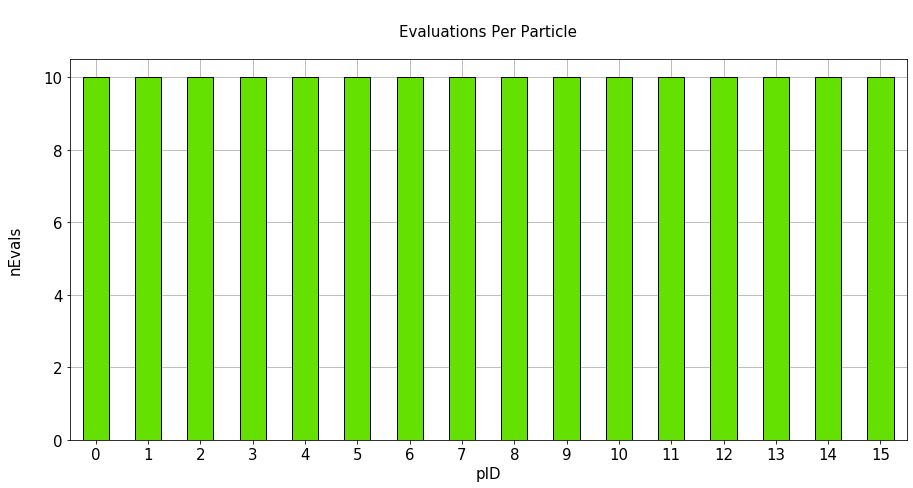

In [18]:
viz.plot_particle_evals( syncSwarm )

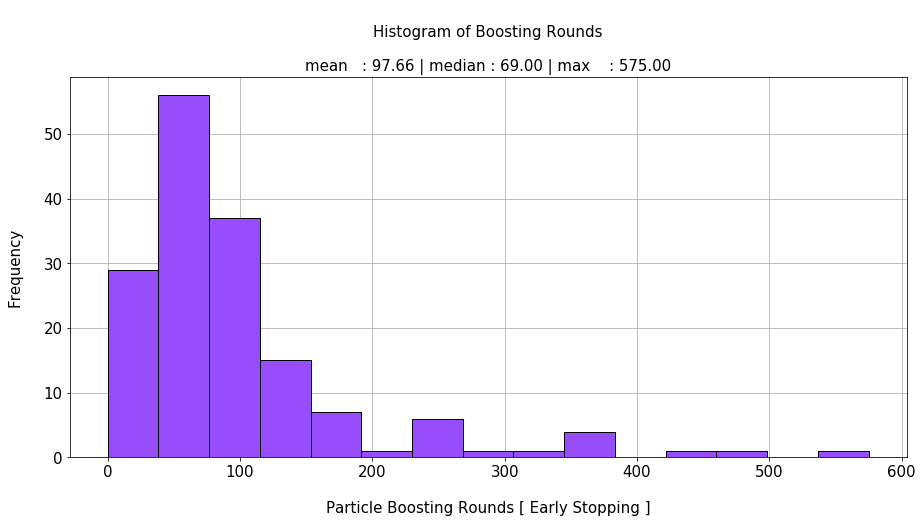

In [19]:
viz.plot_boosting_rounds_histogram(syncSwarm)

In [20]:
viz.viz_top_particles(syncSwarm)

In [21]:
viz.viz_swarm( syncSwarm, syncSwarm.paramRanges)

# Run HPO - <font color='#7400ff'> Asynchronous Swarm </font>

In [22]:
asyncSwarm = swarm.AsyncSwarm( client, dataset, paramRanges, nParticles = 16, nEpochs = 10 )

! initializing AsyncSwarm, with 16 particles, and 10 epochs


In [23]:
asyncSwarm.run_search( syncWarmupFlag = True )

sync warmup

   pID |      max_depth,  learning_rate,          gamma
     0 |              2,           0.00,           0.00 
     1 |              7,           1.87,           3.00 
     2 |             10,           1.86,           1.45 
     3 |             12,           1.68,           1.71 
     4 |             12,           0.35,           1.83 
     5 |              5,           1.66,           2.94 
     6 |             12,           0.42,           1.11 
     7 |              6,           0.88,           2.93 
     8 |              5,           0.48,           2.45 
     9 |             14,           0.99,           0.43 
    10 |             11,           0.99,           2.50 
    11 |             11,           1.33,           2.78 
    12 |             13,           1.75,           2.17 
    13 |              4,           1.72,           0.54 
    14 |             13,           1.32,           0.45 
    15 |             15,           2.00,           3.00 
new best 0.49984 fo

## Visualize <font color='#7400ff'> Asynchronous Swarm </font>

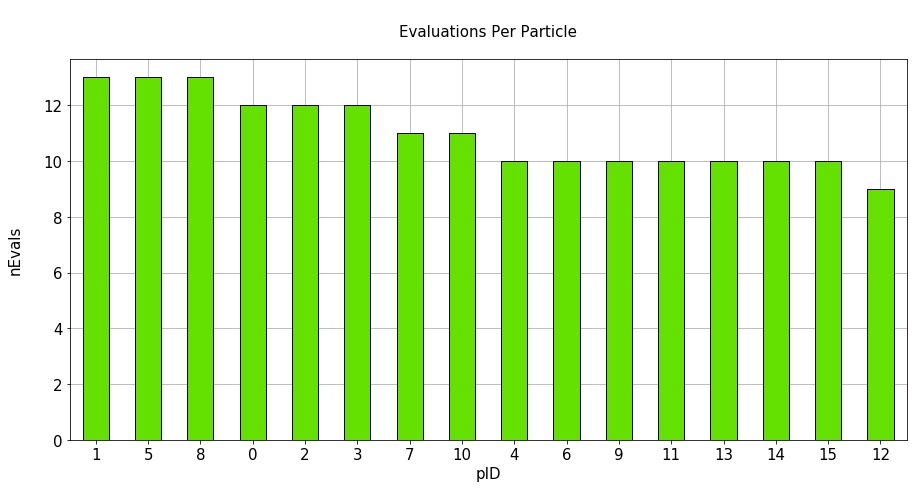

In [24]:
viz.plot_particle_evals( asyncSwarm )

In [25]:
viz.viz_particle_trails( asyncSwarm, topN = 1 )

In [26]:
viz.viz_swarm( asyncSwarm, asyncSwarm.paramRanges )

# Run HPO - <font color='#666666'> Random Search </font>

In [27]:
randomAsyncSwarm = swarm.RandomSearchAsync ( client, dataset, paramRanges, nParticles = 8, nEpochs = 5 )


! initializing RandomSearchAsync, with 8 particles, and 5 epochs


In [28]:
randomAsyncSwarm.run_search()


   pID |      max_depth,  learning_rate,          gamma
     0 |              2,           0.00,           0.00 
     1 |              7,           1.87,           3.00 
     2 |             10,           1.86,           1.45 
     3 |             12,           1.68,           1.71 
     4 |             12,           0.35,           1.83 
     5 |              5,           1.66,           2.94 
     6 |             12,           0.42,           1.11 
     7 |             15,           2.00,           3.00 
new best 0.91713 found by particle 6 on eval 0
> async epoch 1 of 5
> async epoch 2 of 5
> async epoch 3 of 5
> async epoch 4 of 5
new best 0.92075 found by particle 4 on eval 33
> async epoch 5 of 5
new best 0.92643 found by particle 1 on eval 47
search completed...


       accuracy : 0.92643
   elapsed time : 27.351 seconds

      parameter | opt. value
----------------------------------
      max_depth : 9
  learning_rate : 0.074
          gamma : 0.788
         nTrees : 304


## Visualize <font color='#666666'> Random Swarm </font>

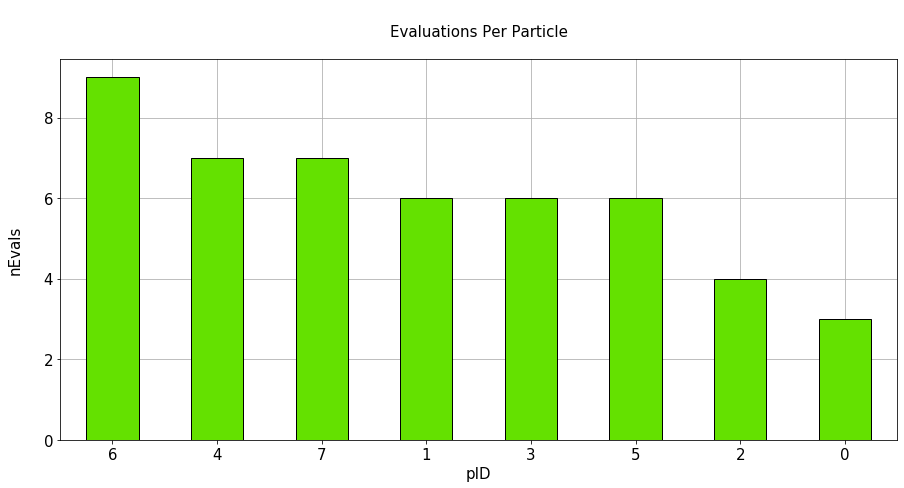

In [29]:
viz.plot_particle_evals( randomAsyncSwarm )

In [30]:
viz.viz_particle_trails( randomAsyncSwarm, topN = 0 )

In [31]:
viz.viz_swarm( randomAsyncSwarm, randomAsyncSwarm.paramRanges )

# Train Model with Best HPO Parameters

In [32]:
# determine best swarm
if syncSwarm.globalBest['accuracy'] > asyncSwarm.globalBest['accuracy']:
    bestSwarm = syncSwarm
else:
    bestSwarm = asyncSwarm

In [33]:
bestParams = {
    'tree_method': 'gpu_hist',
    'random_state': 0, 
    'max_depth': int(bestSwarm.globalBest['params'][0]),
    'learning_rate': bestSwarm.globalBest['params'][1],
    'gamma': bestSwarm.globalBest['params'][2]
}
    
bestParams['objective'] = dataset.trainObjective[0]
if dataset.trainObjective[1] is not None: 
    bestParams['num_class'] = dataset.trainObjective[1]

In [34]:
%%time
trainDMatrix = xgboost.DMatrix( data = dataset.trainData, label = dataset.trainLabels )
testDMatrix = xgboost.DMatrix( data = dataset.testData, label = dataset.testLabels )
trainedModelGPU = xgboost.train( dtrain = trainDMatrix, evals = [(testDMatrix, 'test')], params = bestParams,
                                 num_boost_round = bestSwarm.globalBest['nTrees'], verbose_eval=False)

CPU times: user 1.95 s, sys: 633 ms, total: 2.59 s
Wall time: 2.44 s


In [35]:
# save best model
trainedModelGPU.save_model('xgb.model.hpo')

In [36]:
from cuml import ForestInference

In [37]:
fm = ForestInference.load( filename='xgb.model.hpo' )
# output_class=False,
# model_type='xgboost'
# threshold=0,
# algo: ?

# Inference with trained model on test data

In [38]:
%%time
testDMatrix = xgboost.DMatrix( data = dataset.testData, label = dataset.testLabels )

CPU times: user 5.91 ms, sys: 325 µs, total: 6.23 ms
Wall time: 4.67 ms


In [39]:
%%time
trainedModelGPU.predict( testDMatrix )

CPU times: user 4.7 ms, sys: 458 µs, total: 5.16 ms
Wall time: 3.41 ms


array([1., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [40]:
%%time
test = dataset.testData.as_gpu_matrix(order='C')

CPU times: user 5.69 s, sys: 78.8 ms, total: 5.77 s
Wall time: 5.69 s


In [41]:
%%time
filPredictions = fm.predict ( test) #testDMatrix )#dataset.testData )

CPU times: user 4.52 ms, sys: 13 µs, total: 4.53 ms
Wall time: 3.52 ms


In [42]:
%%time
filPredictions = fm.predict ( dataset.testData )

CPU times: user 235 ms, sys: 13.8 ms, total: 249 ms
Wall time: 229 ms


In [43]:
testDataPerf = 1 - float( trainedModelGPU.eval( testDMatrix ).split(':')[1] )
print(f'accuracy: {testDataPerf}')

accuracy: 0.9275329999999999


In [44]:
from xgboost import plot_tree

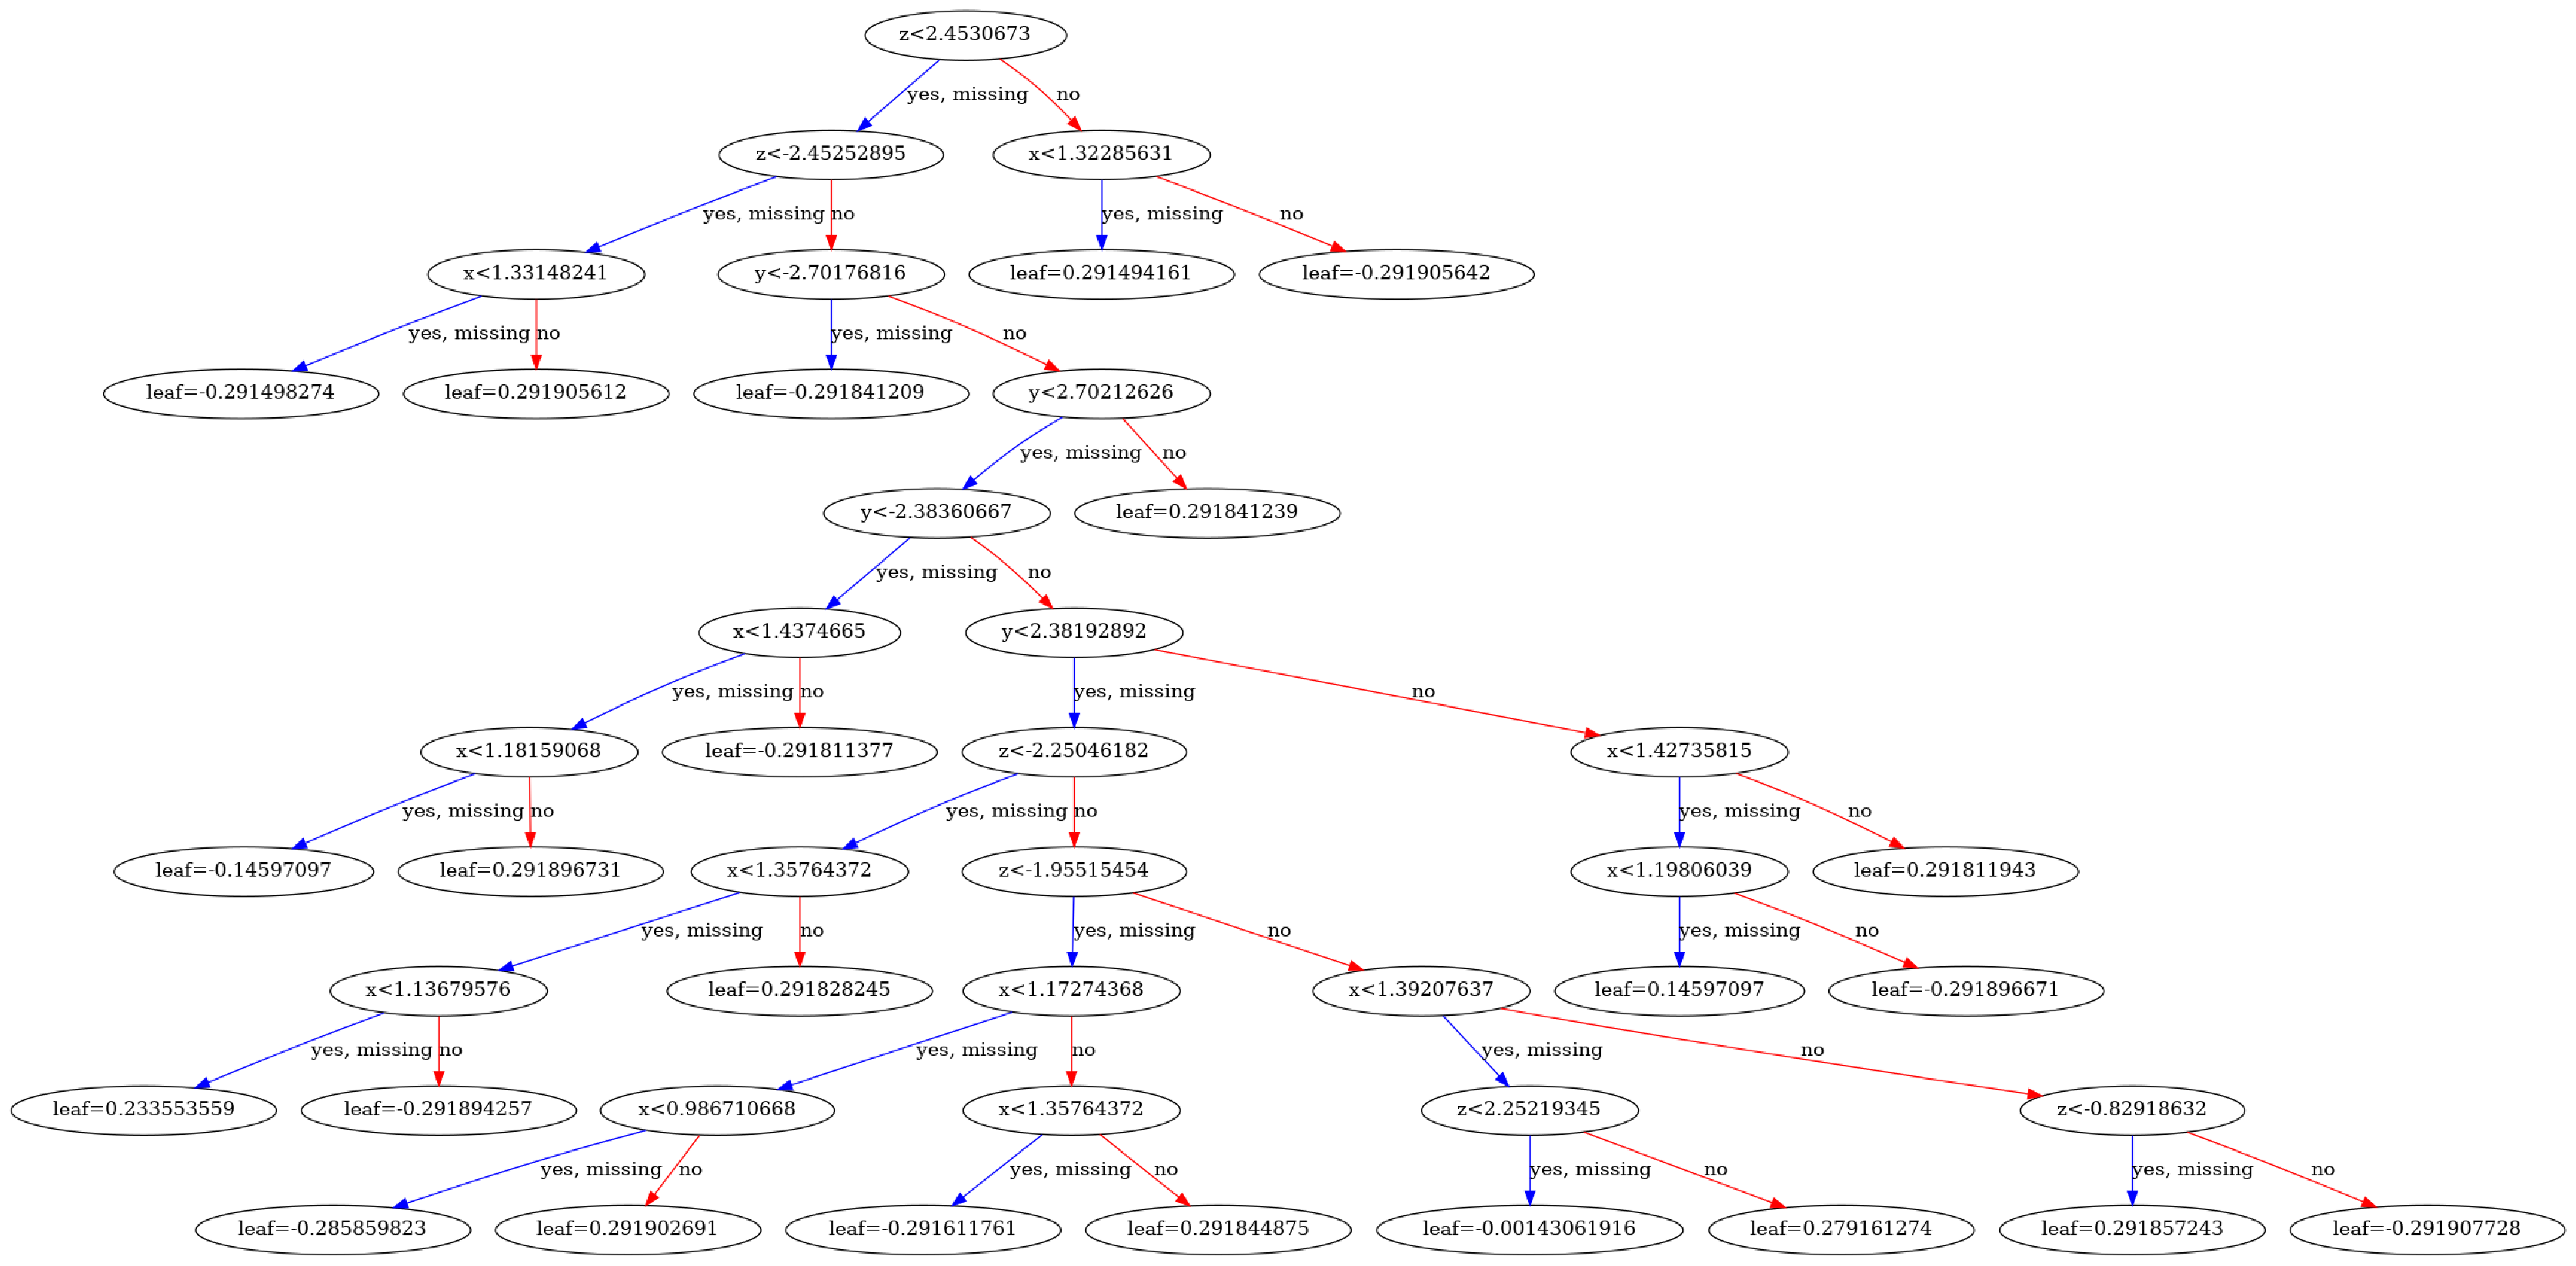

In [45]:
fig = plt.figure( figsize = ( 100, 30) ); ax = plt.subplot(111)
plot_tree( trainedModelGPU, ax = ax)

# Scale Up Results [ DGX-2 ]

<img src='images/synthetic_async.png'></img>

# Summary

# Future Work / Extensions

larger than single GPU memory datasets - dask_cudf + [ dask_xgboost or xgboost.dask ]

# References